### Analysing previous trajectory with DRIVER

In [1]:
import plumed

In [2]:
with open('plumed.dat', 'w') as f:
    f.write('''
    # Activate MOLINFO functionalities
    MOLINFO STRUCTURE=solvated.pdb

    # Get the distance between the first and second atom
    d1: DISTANCE ATOMS=1,2

    # Print the distance every step
    PRINT ARG=d1 FILE=COLVAR STRIDE=1
    ''')

In [12]:
dt = 0.004 # in picoseconds
dt_log = 10000 * dt

!plumed driver --plumed plumed.dat --mf_dcd traj.out --timestep {dt_log}


DRIVER: Found molfile format trajectory dcd with name traj.out
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.9.2 (git: Unknown) compiled on Sep  4 2024 at 12:28:06
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /opt/homebrew/anaconda3/envs/openmm/lib/plumed
PLUMED: For installed feature, see /opt/homebrew/anaconda3/envs/openmm/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 28504
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named solvated.pdb contains 4 chains 
PLUMED:   chain named A contains residues 1 to 100 and atoms 1 to

In [10]:
from openmm import *
from openmm.app import *
from openmm.unit import *
from openmm import unit

import random
import numpy as np
random.seed(42)
np.random.seed(42)

pdf = PDBFile('solvated.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

# System Configuration
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers  #This cutoff and the following for tolerance are standard values
ewaldErrorTolerance = 10**(-4)
constraints = HBonds
rigidWater = True
constraintTolerance = 10**(-4) #Quite a default value for accuracy

# Integration Options
fs = 0.001 * picoseconds
dt = 4 * fs
temperature = 300*kelvin
friction = 1.0/picosecond

# Simulation Options
steps = 10**6
equilibrationSteps = 10**5
# platform = Platform.getPlatformByName('OpenCL')
platform = Platform.getPlatformByName('Reference')

dcdReporter = DCDReporter('traj.out', 10000)
dataReporter = StateDataReporter('logger',10000, totalSteps=steps,
    step=True, time=True, speed=True, potentialEnergy=True, kineticEnergy=True, totalEnergy=True, temperature=True, separator='\t')
checkpointReporter = CheckpointReporter('checkpoint', 10000)

# Prepare the Simulation
print('Building system...')
topology = pdf.topology
positions = pdf.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)
# Optionally, add a barostat to the system
barostat = MonteCarloBarostat(1 * unit.atmosphere, 300 * unit.kelvin)
system.addForce(barostat)

## Minimize and Equilibrate. First, minimize ONLY positions of H atoms
## Create a dictionary to map atom indices to their types
atom_types = {}
for atom in topology.atoms():
    atom_types[atom.index] = atom.element.symbol  # Use element symbol or type
#
## Identify hydrogen atoms
hydrogen_indices = [index for index, element in atom_types.items() if element == 'H']
#
## Apply constraints to non-hydrogens
#for i in range(system.getNumParticles()):
#    if i not in hydrogen_indices:
#        # Apply constraints to keep non-hydrogens fixed
#        system.addConstraint(i, i, 0.0)  # Constraint with zero distance

# Add a custom external force to fix atom positions
fix_force = openmm.CustomExternalForce('0.5*k*(x^2 + y^2 + z^2)')
fix_force.addPerParticleParameter('k')
k = 1e10 * unit.kilojoules_per_mole / unit.nanometers**2  # Large force constant
for i in range(system.getNumParticles()):
    if i not in hydrogen_indices:
#for atomIndex in non_hydrogen_atom_indices:
#      fix_force.addParticle(atomIndex, [k])
      fix_force.addParticle(i, [k])
system.addForce(fix_force)


print('Performing energy minimization...')
simulation.minimizeEnergy()

minimized_positions = simulation.context.getState(getPositions=True).getPositions()

#Now recreate the system but with no constraints
system = forcefield.createSystem(topology,
                                      nonbondedMethod=nonbondedMethod,
                                      nonbondedCutoff=nonbondedCutoff,
                                      constraints=HBonds)

print('Initiate second minimization...')
#Set the positions to the values obtained after minimization
simulation.context.setPositions(minimized_positions)

#Re-minimize but allow all atoms to move
simulation.minimizeEnergy()

#Equilibrate
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# save equilibrated positions
equilibrated_positions = simulation.context.getState(getPositions=True).getPositions()
with open('equilibrated.pdb', 'w') as f:
    PDBFile.writeFile(topology, equilibrated_positions, f)

# Simulate
print('Simulating...')
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)
simulation.currentStep = 0
simulation.step(steps)


Building system...


In [1]:
import mdtraj as md
import numpy as np
import itertools

Number of CA atoms in chain A: 100
Number of CA atoms in chain B: 50
First few CA atom indices in chain A: [ 4 16 38 52 69]
First few CA atom indices in chain B: [1644 1661 1672 1686 1698]
Chain A indices: [   4   16   38   52   69   79  100  117  129  148  170  191  207  217
  228  242  249  261  278  299  314  326  341  358  373  397  418  438
  457  471  485  496  515  532  552  569  590  607  617  631  643  660
  681  705  726  733  753  763  780  799  818  830  847  861  878  885
  902  914  930  945  959  978  997 1011 1035 1047 1062 1077 1091 1111
 1128 1152 1167 1187 1211 1226 1243 1264 1280 1295 1309 1321 1338 1359
 1376 1393 1412 1423 1442 1462 1481 1495 1512 1533 1549 1568 1583 1607
 1614 1624]
Chain B indices: [1644 1661 1672 1686 1698 1708 1719 1741 1756 1772 1782 1792 1807 1826
 1846 1868 1888 1902 1919 1936 1950 1971 1982 1996 2020 2034 2049 2066
 2088 2103 2123 2143 2160 2167 2184 2206 2220 2236 2253 2265 2275 2285
 2306 2327 2347 2361 2373 2395 2409 2423]
Contact map: 

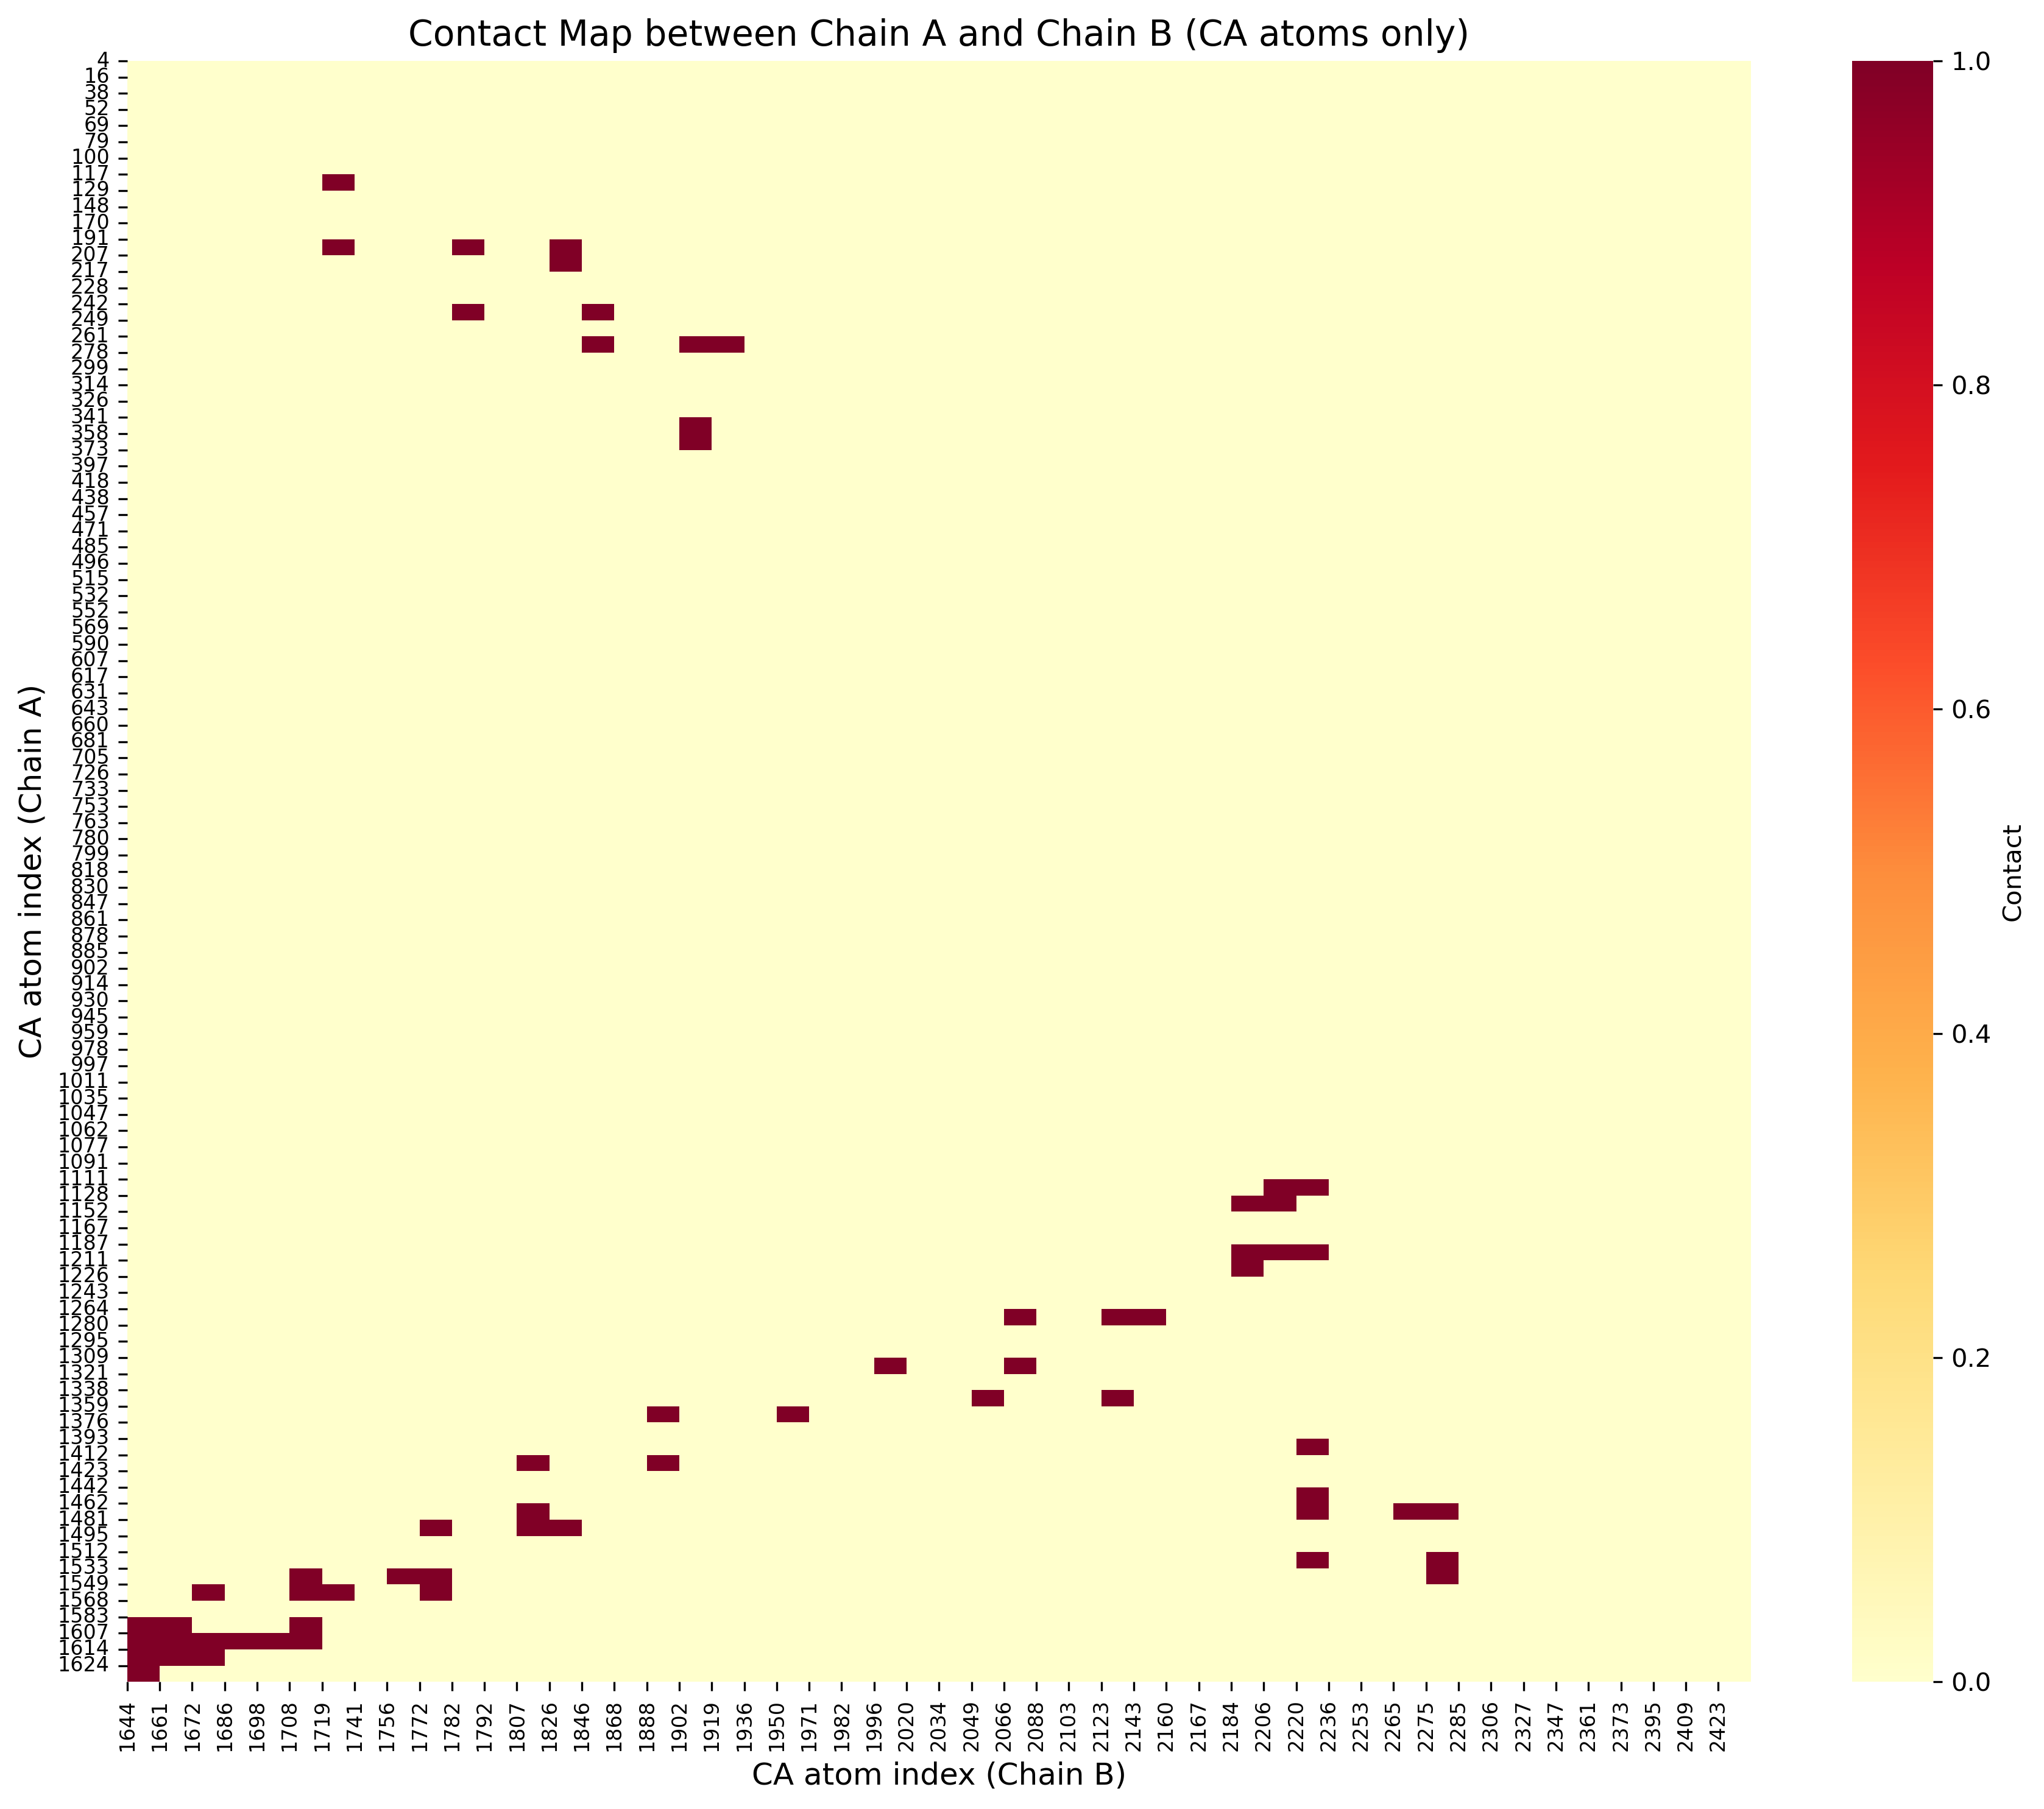

Total contacts between CA atoms: 63
Percentage of CA atom pairs in contact: 1.26%
Contact pairs:  [[ 7  6]
 [11  6]
 [11 10]
 [11 13]
 [12 13]
 [15 10]
 [15 14]
 [17 14]
 [17 17]
 [17 18]
 [22 17]
 [23 17]
 [69 35]
 [69 36]
 [70 34]
 [70 35]
 [73 34]
 [73 35]
 [73 36]
 [74 34]
 [77 27]
 [77 30]
 [77 31]
 [80 23]
 [80 27]
 [82 26]
 [82 30]
 [83 16]
 [83 20]
 [85 36]
 [86 12]
 [86 16]
 [88 36]
 [89 12]
 [89 36]
 [89 39]
 [89 40]
 [90  9]
 [90 12]
 [90 13]
 [92 36]
 [92 40]
 [93  5]
 [93  8]
 [93  9]
 [93 40]
 [94  2]
 [94  5]
 [94  6]
 [94  9]
 [96  0]
 [96  1]
 [96  5]
 [97  0]
 [97  1]
 [97  2]
 [97  3]
 [97  4]
 [97  5]
 [98  0]
 [98  1]
 [98  2]
 [99  0]]
Carbon alpha indices:  [(118, 1720), (192, 1720), (192, 1783), (192, 1827), (208, 1827), (243, 1783), (243, 1847), (262, 1847), (262, 1903), (262, 1920), (342, 1903), (359, 1903), (1112, 2207), (1112, 2221), (1129, 2185), (1129, 2207), (1188, 2185), (1188, 2207), (1188, 2221), (1212, 2185), (1265, 2067), (1265, 2124), (1265, 2144), 

In [17]:
# Load the PDB file
traj = md.load('equilibrated.pdb')

# Get atom indices for chain A and chain B, considering only carbon alpha atoms
chain_A_indices = traj.topology.select('chainid 0 and name CA')  # Chain A, only CA atoms
chain_B_indices = traj.topology.select('chainid 1 and name CA')  # Chain B, only CA atoms

print(f"Number of CA atoms in chain A: {len(chain_A_indices)}")
print(f"Number of CA atoms in chain B: {len(chain_B_indices)}")

print("First few CA atom indices in chain A:", chain_A_indices[:5])
print("First few CA atom indices in chain B:", chain_B_indices[:5])

# Compute contact map between chain A and chain B
def compute_contact_map(traj, chain_A_indices, chain_B_indices, cutoff=0.8):
    # Calculate distances between all pairs of CA atoms in chain A and chain B
    distances = md.compute_distances(traj, np.array(list(itertools.product(chain_A_indices, chain_B_indices))))
    
    # Reshape the distances array to match the number of CA atoms in each chain
    n_res_A = len(chain_A_indices)
    n_res_B = len(chain_B_indices)
    contact_map = distances.reshape(n_res_A, n_res_B)
    
    # Convert distances to binary contact map (1 if contact, 0 if not)
    contact_map = (contact_map < cutoff).astype(int)
    
    return contact_map

# Compute the contact map
contact_map = compute_contact_map(traj, chain_A_indices, chain_B_indices)

print(f"Chain A indices: {chain_A_indices}")
print(f"Chain B indices: {chain_B_indices}")

print(f"Contact map: {contact_map}")

# Visualize the contact map as a histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10), dpi=300)
sns.heatmap(contact_map, cmap='YlOrRd', cbar_kws={'label': 'Contact'})
plt.title('Contact Map between Chain A and Chain B (CA atoms only)', fontsize=14)
plt.xlabel('CA atom index (Chain B)', fontsize=12)
plt.ylabel('CA atom index (Chain A)', fontsize=12)
plt.xticks(range(len(chain_B_indices)), chain_B_indices, rotation=90, fontsize=8)
plt.yticks(range(len(chain_A_indices)), chain_A_indices, rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('contact_map.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"Total contacts between CA atoms: {np.sum(contact_map)}")
print(f"Percentage of CA atom pairs in contact: {np.sum(contact_map) / (contact_map.shape[0] * contact_map.shape[1]) * 100:.2f}%")

# Find pairs below the cutoff
contact_pairs = np.argwhere(contact_map == 1)

print("Contact pairs: ", contact_pairs)

carbon_alpha_indices = []
for index_in_chain_A, index_in_chain_B in contact_pairs:
    # +1 because PLUMED uses 1-based indexing
    carbon_alpha_indices.append((chain_A_indices[index_in_chain_A]+1, chain_B_indices[index_in_chain_B]+1))

print("Carbon alpha indices: ", carbon_alpha_indices)

In [15]:
print(f"WHOLEMOLECULES ENTITY0={chain_A_indices[0]+1}-{chain_A_indices[-1]+1} ENTITY1={chain_B_indices[0]+1}-{chain_B_indices[-1]+1}")

WHOLEMOLECULES ENTITY0=5-1625 ENTITY1=1645-2424


In [18]:
# TODO: what does this R0 mean here?

contact_pairs_str = ""
for i, pair in enumerate(carbon_alpha_indices):
    contact_pairs_str += f"\n\tATOMS{i+1}={pair[0]},{pair[1]}"

print(f"""
cmap: CONTACTMAP ... {contact_pairs_str}
\tSWITCH={{RATIONAL R_0=0.8}}
\tSUM
...
""")


cmap: CONTACTMAP ... 
	ATOMS1=118,1720
	ATOMS2=192,1720
	ATOMS3=192,1783
	ATOMS4=192,1827
	ATOMS5=208,1827
	ATOMS6=243,1783
	ATOMS7=243,1847
	ATOMS8=262,1847
	ATOMS9=262,1903
	ATOMS10=262,1920
	ATOMS11=342,1903
	ATOMS12=359,1903
	ATOMS13=1112,2207
	ATOMS14=1112,2221
	ATOMS15=1129,2185
	ATOMS16=1129,2207
	ATOMS17=1188,2185
	ATOMS18=1188,2207
	ATOMS19=1188,2221
	ATOMS20=1212,2185
	ATOMS21=1265,2067
	ATOMS22=1265,2124
	ATOMS23=1265,2144
	ATOMS24=1310,1997
	ATOMS25=1310,2067
	ATOMS26=1339,2050
	ATOMS27=1339,2124
	ATOMS28=1360,1889
	ATOMS29=1360,1951
	ATOMS30=1394,2221
	ATOMS31=1413,1808
	ATOMS32=1413,1889
	ATOMS33=1443,2221
	ATOMS34=1463,1808
	ATOMS35=1463,2221
	ATOMS36=1463,2266
	ATOMS37=1463,2276
	ATOMS38=1482,1773
	ATOMS39=1482,1808
	ATOMS40=1482,1827
	ATOMS41=1513,2221
	ATOMS42=1513,2276
	ATOMS43=1534,1709
	ATOMS44=1534,1757
	ATOMS45=1534,1773
	ATOMS46=1534,2276
	ATOMS47=1550,1673
	ATOMS48=1550,1709
	ATOMS49=1550,1720
	ATOMS50=1550,1773
	ATOMS51=1584,1645
	ATOMS52=1584,1662
	ATOMS53=1

In [3]:
from openmmplumed import PlumedForce

In [23]:
# validate my plumed.dat file
!plumed driver --plumed plumed_.dat --mf_dcd traj_unbiased.dcd --timestep 0.004


DRIVER: Found molfile format trajectory dcd with name traj_unbiased.dcd
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.9.2 (git: Unknown) compiled on Sep  4 2024 at 12:23:39
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/jakub/anaconda3/envs/openmm/lib/plumed
PLUMED: For installed feature, see /home/jakub/anaconda3/envs/openmm/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 28504
PLUMED: File suffix: 
PLUMED: FILE: plumed_.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named equilibrated.pdb contains 4 chains 
PLUMED:   chain named A contains residues 1 to 100 and 

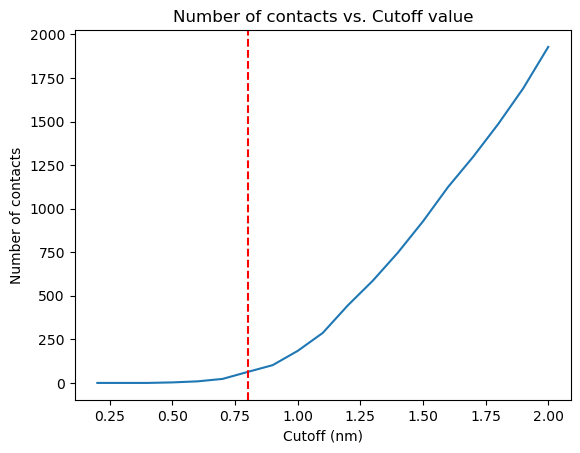

In [24]:

cuttoffs = np.arange(0.2, 2.1, 0.1) 
num_contacts = []
for cutoff in cuttoffs:
    contact_map = compute_contact_map(traj, chain_A_indices, chain_B_indices, cutoff)
    num_contacts.append(np.sum(contact_map))

plt.plot(cuttoffs, num_contacts)
plt.xlabel('Cutoff (nm)')
plt.ylabel('Number of contacts')
plt.title('Number of contacts vs. Cutoff value')
# plot vertical line at 0.8
plt.axvline(x=0.8, color='r', linestyle='--', label='R0=0.8')
plt.show()

In [25]:
import MDAnalysis as mda

# Load the trajectory
u = mda.Universe('equilibrated.pdb', 'traj_unbiased.dcd')

# Print the number of atoms
print(u.atoms.n_atoms)

/home/jakub/anaconda3/envs/openmm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


28504


/home/jakub/anaconda3/envs/openmm/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/jakub/anaconda3/envs/openmm/lib/libplumedKernel.so" +++
/tmp/ipykernel_20744/1473777951.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = plumed.read_as_pandas('colvar_unbiased')


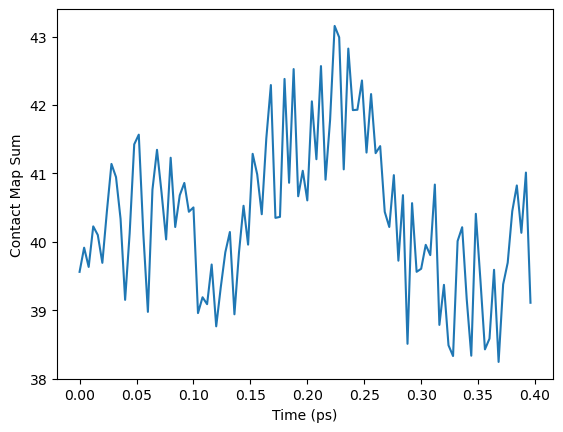

std 1.126321563892865
1/3 std 0.3754405212976217
1/2 std 0.5631607819464325


In [26]:
import plumed
import matplotlib.pyplot as plt

df = plumed.read_as_pandas('colvar_unbiased')
# plot cmap as a function of time
plt.plot(df['time'], df['cmap'])
plt.xlabel('Time (ps)')
plt.ylabel('Contact Map Sum')
plt.show()

# print the std of cmap
print('std', df['cmap'].std())
# get 1/3 of std and 1/2 of std and print them nicely, i.e. give the range
print('1/3 std', df['cmap'].std()/3)
print('1/2 std', df['cmap'].std()/2)


In [3]:
import plumed
import matplotlib.pyplot as plt

df = plumed.read_as_pandas('colvar_metad')
# plot cmap as a function of time
plt.plot(df['time'], df['cmap'])
plt.xlabel('Time (ps)')
plt.ylabel('Contact Map Sum')
plt.show()

ModuleNotFoundError: No module named 'plumed'

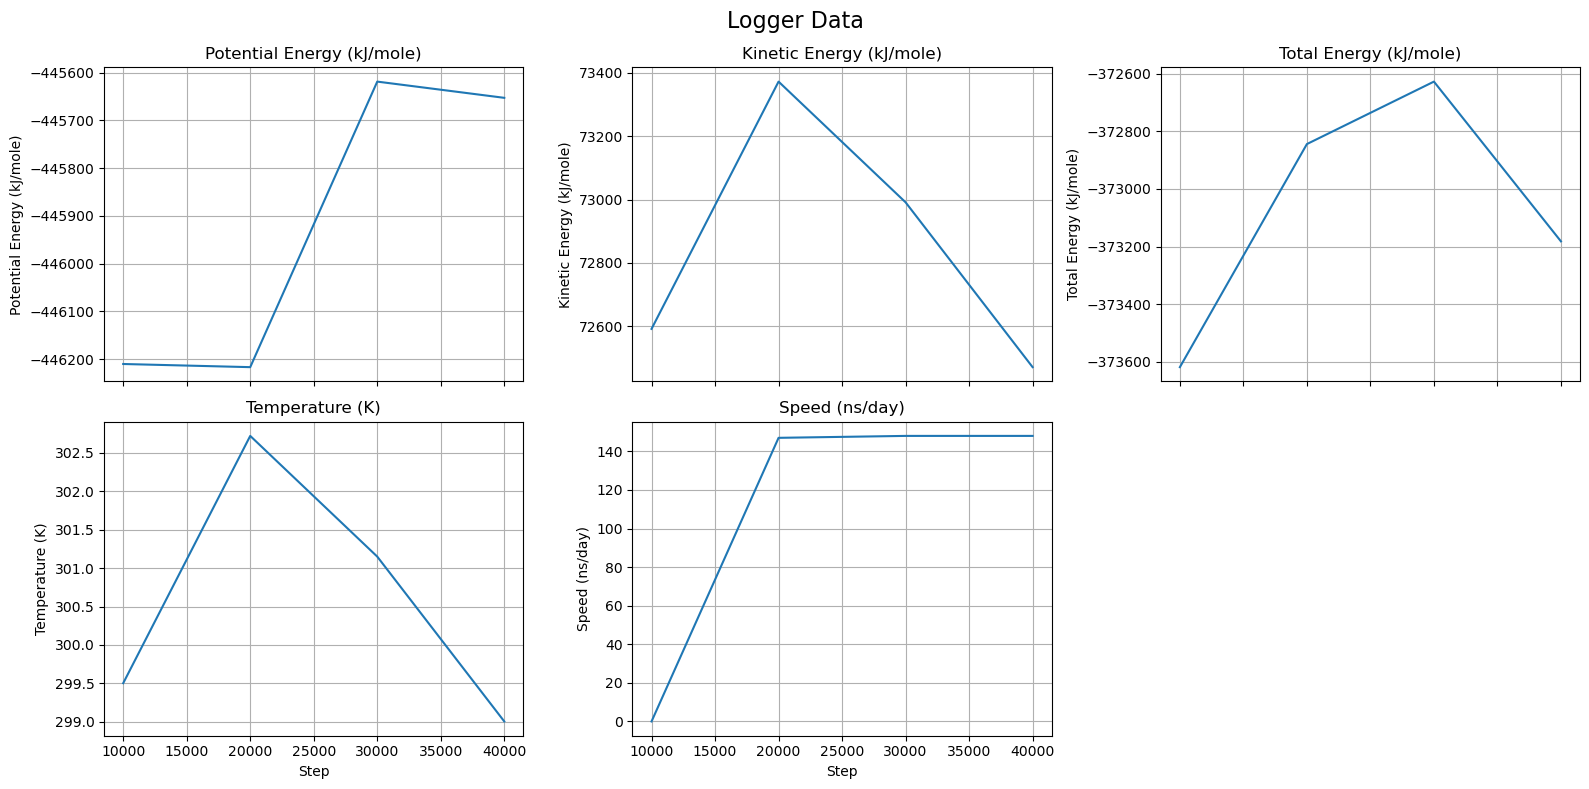

In [27]:
# read the logger file and plot it
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('logger', sep='\t')

# Define columns to exclude
exclude_cols = ['Time (ps)', 'Density (g/mL)', 'Box Volume (nm^3)', 'Time Remaining']

# Get the columns to plot (excluding the ones we don't want and checking for 'Progress' in column name)
plot_cols = [col for col in df.columns if col not in exclude_cols and col != 'Step' and 'Progress' not in col]

# Calculate the number of rows and columns for the subplots
n_cols = 3
n_rows = (len(plot_cols) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows), sharex=True)
fig.suptitle('Logger Data', fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(plot_cols):
    axes[i].plot(df['Step'], df[col])
    axes[i].set_ylabel(col)
    axes[i].set_title(col)
    axes[i].grid(True)

# Remove any unused subplots
for i in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[i])

# Set the x-label for all subplots in the bottom row
for ax in axes[-n_cols:]:
    ax.set_xlabel('Step')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


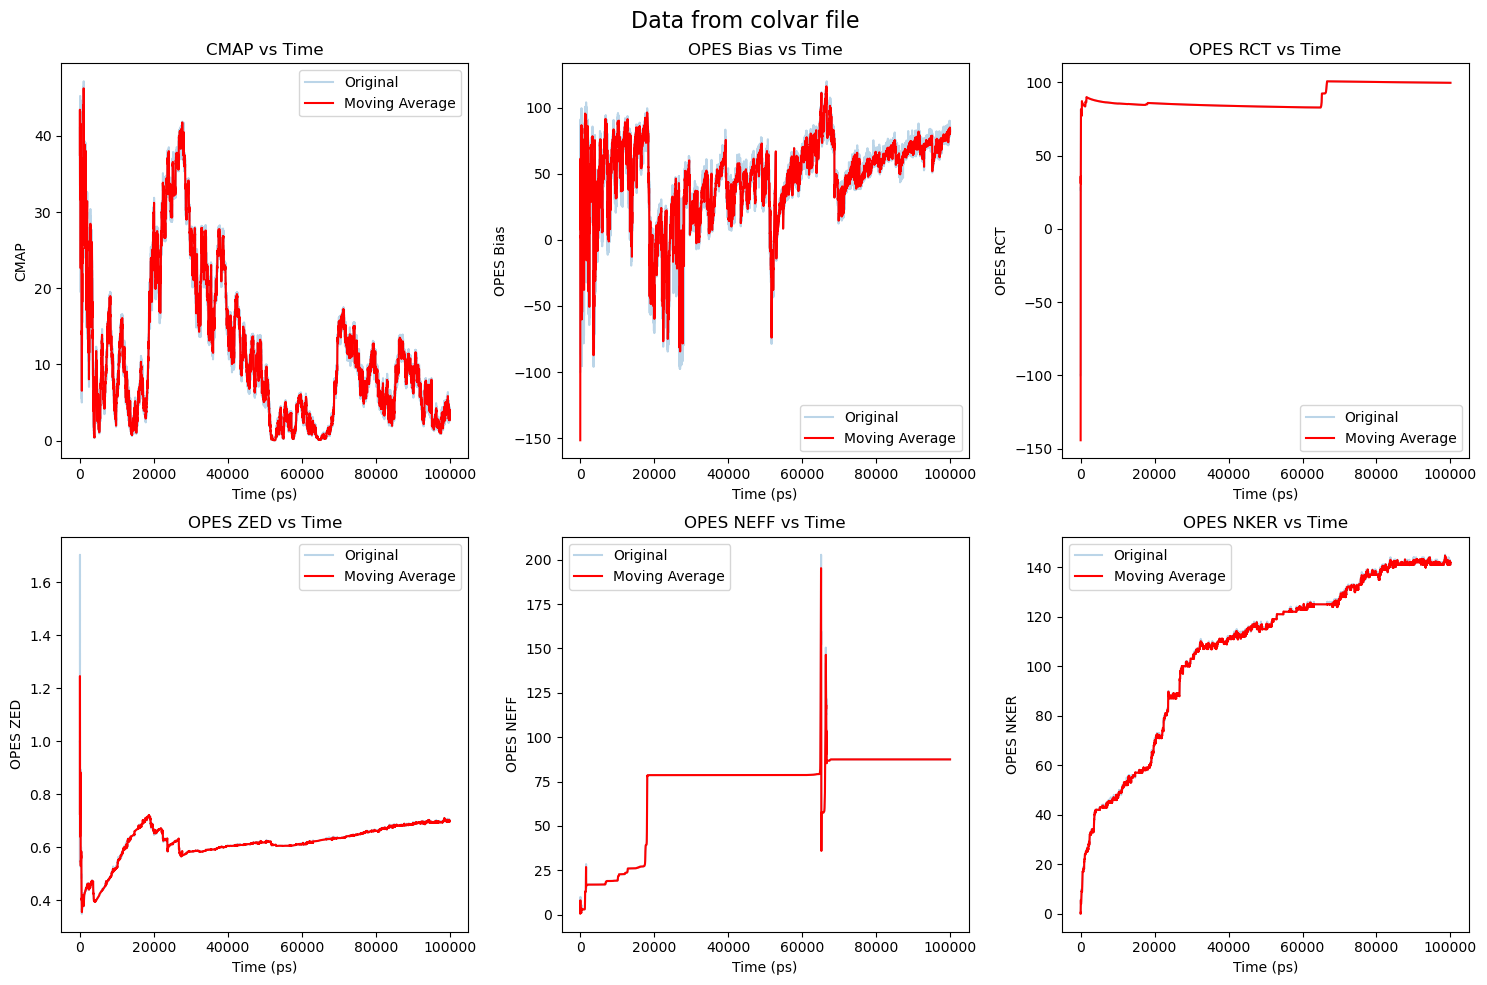

In [1]:
# Read colvar_first_opes file using pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

stride = 500
timestep = 0.004 / 2

filename = 'colvar'

# Read the data from the colvar file
data = np.loadtxt(filename, skiprows=1)

# Extract time and other columns
time = data[:, 0]
columns = ['CMAP', 'OPES Bias', 'OPES RCT', 'OPES ZED', 'OPES NEFF', 'OPES NKER']
values = data[:, 1:]

# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Data from {filename} file', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each variable in a separate subplot
for i, (ax, column) in enumerate(zip(axs, columns)):
    # Plot original data with low alpha
    time_ps = time * stride * timestep
    ax.plot(time_ps, values[:, i], alpha=0.3, label='Original')
    
    # Calculate and plot moving average
    window_size = 51  # Adjust this for smoother or less smooth curve
    moving_avg = savgol_filter(values[:, i], window_size, 3)  # 3 is the polynomial order
    # Recompute time axis to account for stride and timestep
    ax.plot(time_ps, moving_avg, color='r', label='Moving Average')
    ax.set_xlabel('Time (ps)')
    
    ax.set_title(f'{column} vs Time')
    ax.set_ylabel(column)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

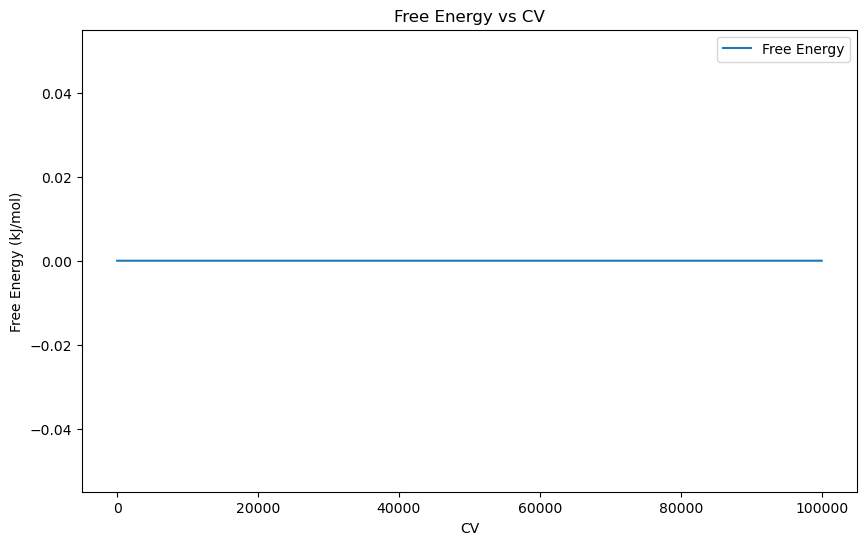

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the COLVAR file
colvar_file = 'colvar'  # Replace with your actual COLVAR file name
data = np.loadtxt(filename, skiprows=1)

cv = data[:, 0]
bias = data[:, 1]

# Define the gamma parameter
gamma = 1.0  # Replace with the actual gamma value used in your OPES simulation

# Compute the free energy
free_energy = -(1 - 1/gamma) * bias

# Plot the free energy
plt.figure(figsize=(10, 6))
plt.plot(cv, free_energy, label='Free Energy')
plt.xlabel('CV')
plt.ylabel('Free Energy (kJ/mol)')
plt.title('Free Energy vs CV')
plt.legend()